### Import Required Libraries

In [2]:
# common libraries
import pandas as pd # data manipulation and extraction
import numpy as np # numerical computation
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import warnings # ignore warnings

# preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,label_binarize
from fast_ml.model_development import train_valid_test_split

# classifcation model and model selection libraries
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit 

# model evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from itertools import cycle

# model inspection libraries
import shap
from scipy.interpolate import interp1d



### Read in the data

In [3]:
data = pd.read_csv('../data/final_predictors.csv')

print(f'Shape of dataframe: {data.shape}')
print('\n')

data.head()

Shape of dataframe: (1321, 20)




,rbs_sexual_activity,meds_methadone_0,rbs_heroine,meds_methadone_2,cows_predose,meds_methadone_3,meds_buprenorphine_0,pex_other_normal,test_Opiate300_3,rbs_other_opiates,dsm_sedative_no_diagnosis,cows_postdose,mdh_asthma_no_history,mdh_head_injury_no_history,test_Opiate300_4,dsm_sedative_abuse,test_Opiate300_2,pex_skin_abnormal,rbs_amphetamines,dropout
0,2.0,0.0,30.0,0.0,11.0,0.0,8.0,0,0.0,0.0,1,6.0,1,1,0.0,0,0.0,0,0.0,0.0
1,3.0,0.0,35.0,0.0,8.0,0.0,8.0,0,1.0,0.0,1,1.0,1,1,1.0,0,1.0,1,0.0,0.0
2,3.0,30.0,90.0,310.0,8.0,420.0,0.0,0,1.0,0.0,1,5.0,1,1,1.0,0,1.0,1,0.0,0.0
3,3.0,0.0,44.0,0.0,11.0,0.0,16.0,0,1.0,1.0,1,9.0,1,1,1.0,0,0.0,0,0.0,0.0
4,1.0,0.0,4.0,0.0,11.0,0.0,16.0,0,1.0,26.0,1,6.0,1,1,1.0,0,1.0,1,0.0,1.0


## Remove Features to prevent data leakage
The opiate tests and self reported use for the final month of treatment are removed to prevent data leakage

### Split the data into training, testing and validation sets

In [4]:
# define parameters
train_size = 0.7
valid_size = 0.1
test_size = 0.2

# split data
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'dropout', 
                                                                            train_size=train_size, valid_size=valid_size, test_size=test_size)

# print shapes of dataframes
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print('\n')
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of y_valid: {y_valid.shape}')
print('\n')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')


Shape of X_train: (924, 19)
Shape of y_train: (924,)


Shape of X_valid: (132, 19)
Shape of y_valid: (132,)


Shape of X_test: (265, 19)
Shape of y_test: (265,)


In [5]:
 # use label encoder to encode labels for y_train, y_test and y_val
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_valid)

### Fit the model

In [6]:
def fit_model(X_train, y_train):
    parameters = [
        {'n_estimators':[150,200,300], 'learning_rate':[0.1,0.01,0.001]}
    ]

    grid_search = GridSearchCV(XGBClassifier(), 
                               parameters,
                               verbose=True, 
                               scoring='f1', 
                               cv=StratifiedShuffleSplit(n_splits=5),
                               n_jobs=8)
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [7]:
grid_search = fit_model(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [8]:
# print best score and best params from grid search
print(f'Best score: {grid_search.best_score_}')
print('\n')
print(f'Best params: {grid_search.best_params_}')
print('\n')
print(f'Accuracy score for training set: {grid_search.score(X_train, y_train)})')

Best score: 0.872424092409241


Best params: {'learning_rate': 0.01, 'n_estimators': 150}


Accuracy score for training set: 0.9102167182662538)


In [9]:
# refit model with best params
xgb = XGBClassifier(learning_rate=0.1, n_estimators=300)

# fit model
xgb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=["auc","error"], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

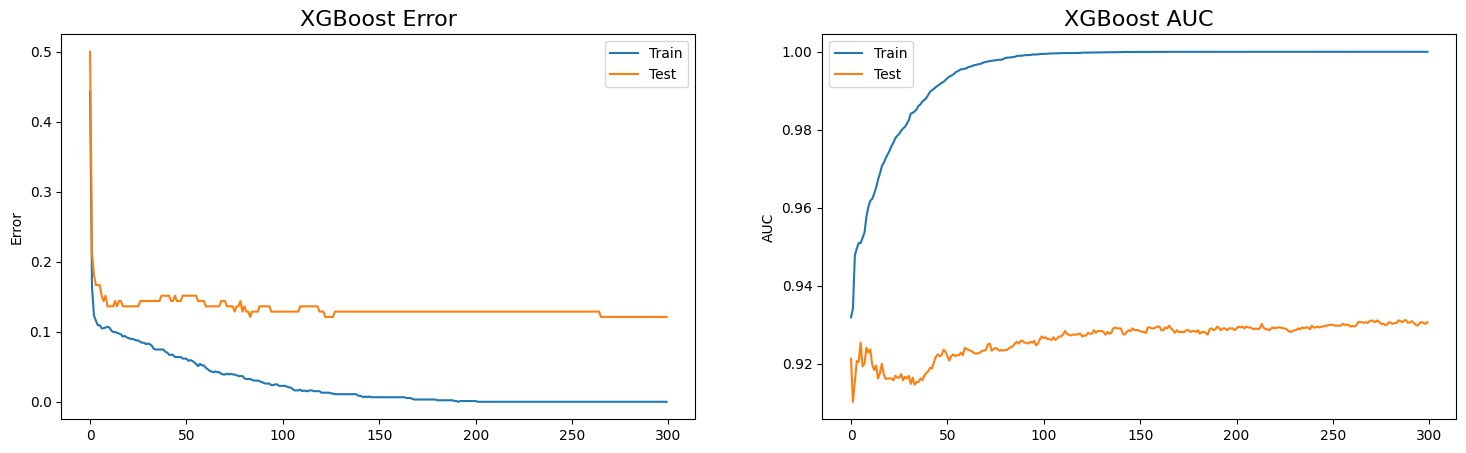

In [10]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


### Evaluate the fitted model

In [11]:
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_valid)
y_pred_test = grid_search.predict(X_test)

y_train_prob = xgb.predict_proba(X_train)
y_val_prob = xgb.predict_proba(X_valid)
y_test_prob = xgb.predict_proba(X_test)

In [12]:
print(classification_report(y_valid,y_pred_val))

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88        66
         1.0       0.87      0.89      0.88        66

    accuracy                           0.88       132
   macro avg       0.88      0.88      0.88       132
weighted avg       0.88      0.88      0.88       132



In [13]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       119
           1       0.91      0.84      0.87       146

    accuracy                           0.86       265
   macro avg       0.86      0.87      0.86       265
weighted avg       0.87      0.86      0.86       265



In [14]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       1.00      1.00      1.00       515

    accuracy                           1.00       924
   macro avg       1.00      1.00      1.00       924
weighted avg       1.00      1.00      1.00       924



In [15]:
# Measure F1 score for training, validation and testing
print('Train Accuracy: %0.3f' % accuracy_score(y_train,y_pred_train))
print('Validation Accuracy: %0.3f' % accuracy_score(y_val,y_pred_val))
print('Test Accuracy: %0.3f' % accuracy_score(y_test,y_pred_test))

Train Accuracy: 1.000
Validation Accuracy: 0.879
Test Accuracy: 0.864


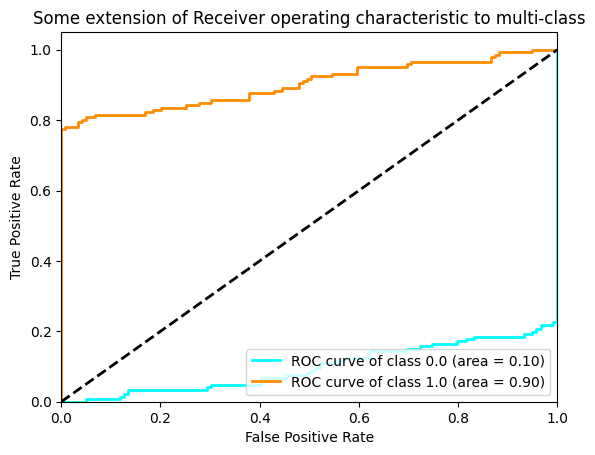

In [16]:
# Plot all ROC curves

#Calculate ROC curve and ROC each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_bin = label_binarize(y_test, classes=[0,1])
n_classes =2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_test_prob[:,i])
    roc_auc[i] = roc_auc_score(y_test, y_test_prob[:,i])
plt.figure()
lw=2
colors = cycle(['aqua', 'darkorange']) #, 'cornflowerblue' ]) #'deeppink','navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

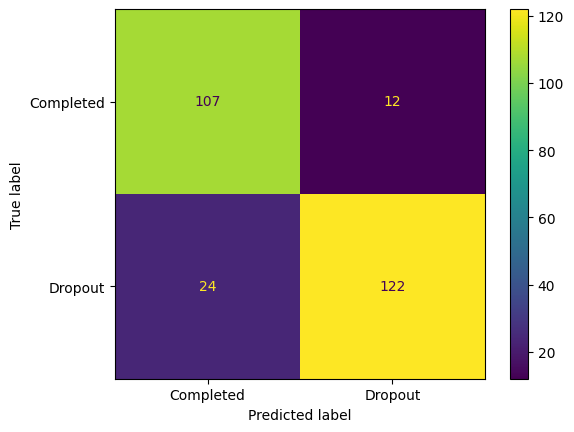

In [17]:
# plot confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Completed', 'Dropout'])
disp.plot();

In [18]:
ex = shap.Explainer(xgb.predict_proba, X_train, max_evals=700)
shap_values = ex(X_test)

PermutationExplainer explainer: 266it [00:22,  7.15it/s]                         


Class index: 1
Data index: 101


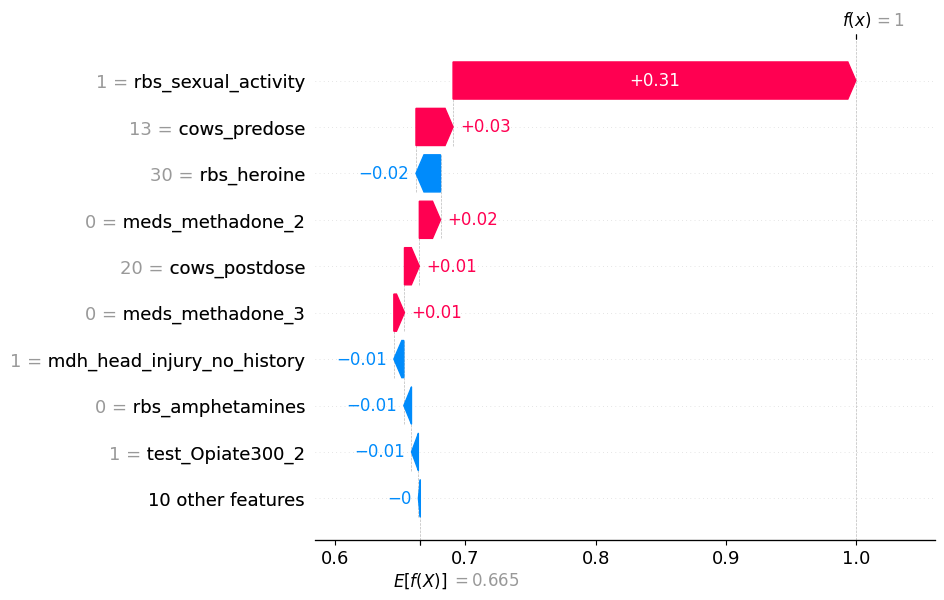

In [19]:
# waterfall plot for clas index 0 
class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.waterfall(shap_values[data_index,:,class_index])

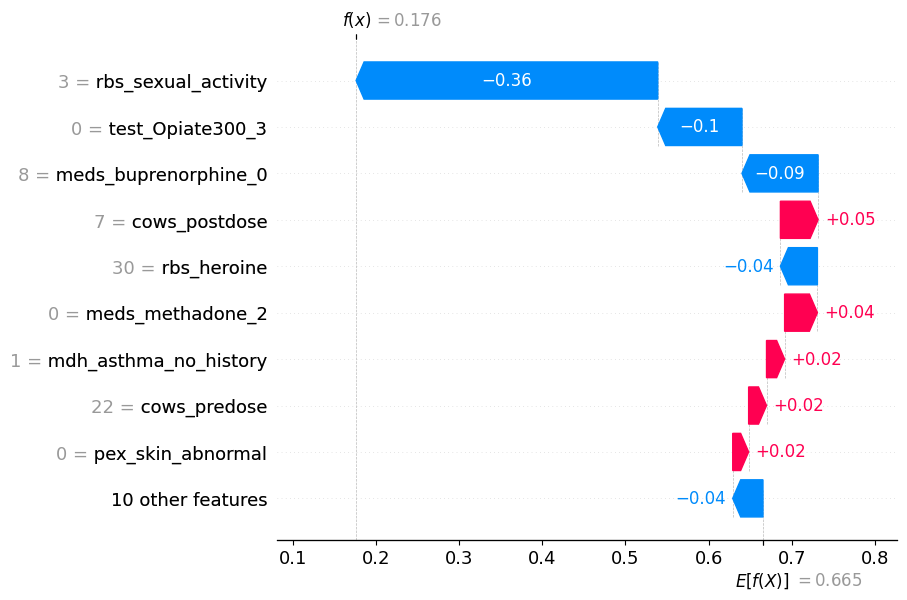

In [20]:
shap.plots.waterfall(shap_values[50,:,1])

Class index: 1
Data index: 16


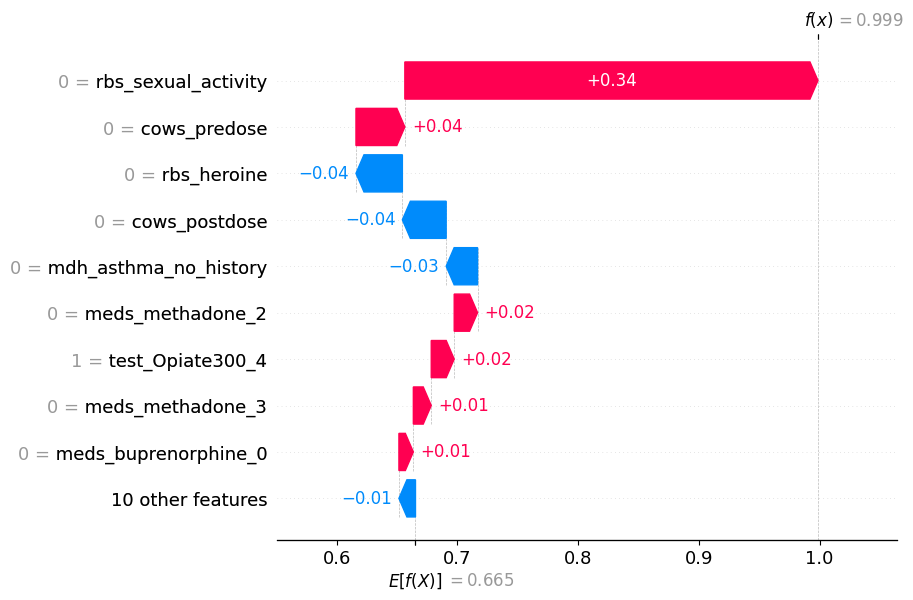

In [21]:
data_index = np.random.choice(shap_values.shape[0])
class_index = 1
print(f'Class index: {class_index}')
print(f'Data index: {data_index}')
shap.plots.waterfall(shap_values[data_index,:,class_index])

Class index: 1
Data index: 246


TypeError: Axis.set_ticks() got an unexpected keyword argument 'fontsize'

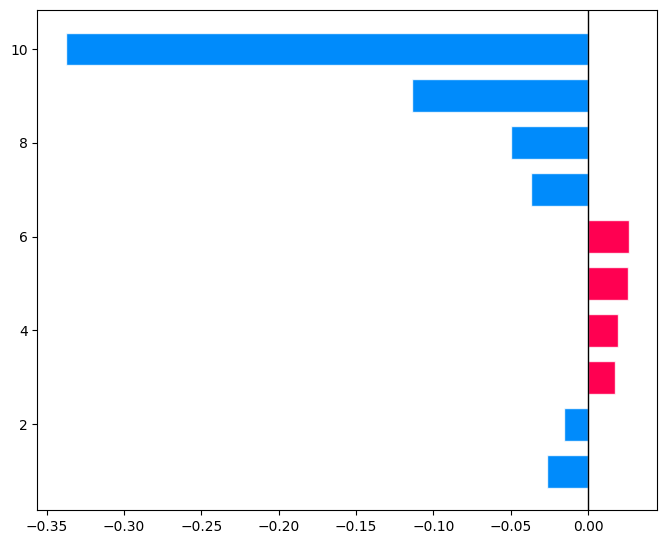

In [22]:
import numpy as np
import shap

class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

# Create the SHAP bar plot
shap.plots.bar(shap_values[data_index, :, class_index], max_display=10)


Class index: 1
Data index: 67


TypeError: Axis.set_ticks() got an unexpected keyword argument 'fontsize'

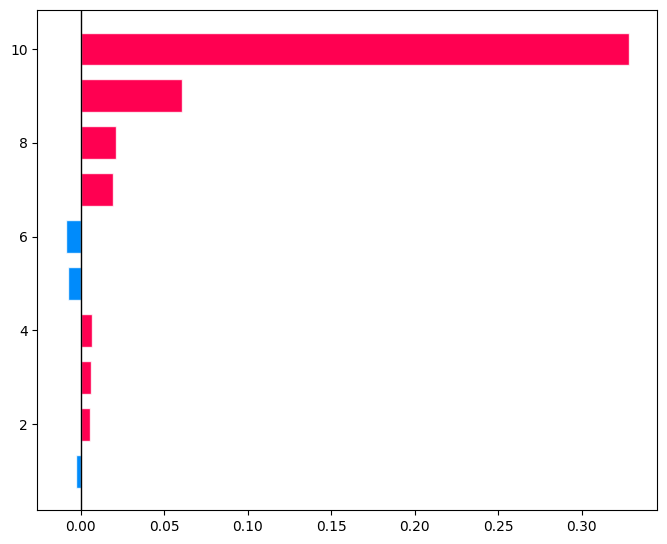

In [ ]:
class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.bar(shap_values[data_index,:,class_index ], max_display=10, show=True)

Class index: 1
Data index: 153


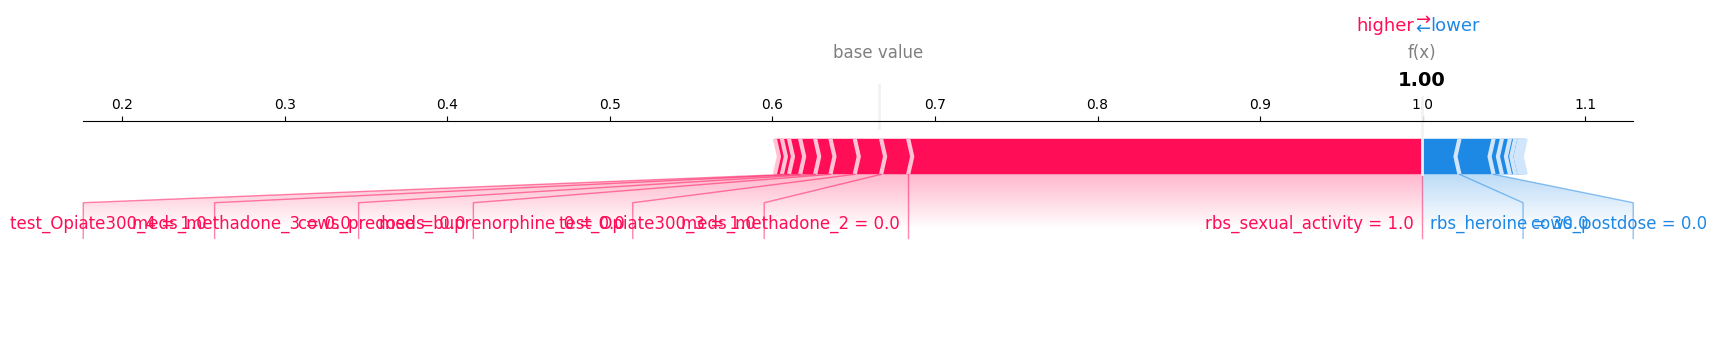

In [23]:
shap.initjs()

class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.force(shap_values[data_index,:,class_index], matplotlib=True, show=True)

Class index: 1


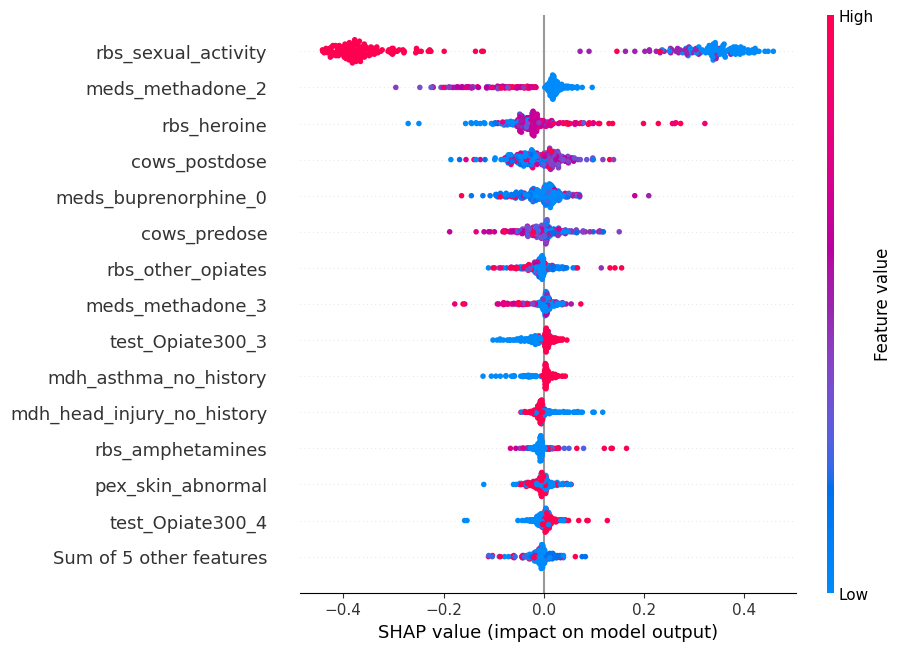

In [27]:
class_index = 1
print(f'Class index: {class_index}')

# shap beeswarm plot
shap.plots.beeswarm(shap_values[:,:,class_index], max_display=15, show=True)

In [36]:
import shap
import xgboost as xgb
import numpy as np

# Assuming X_train, y_train, X_test are already defined
# Train the model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)


In [37]:
X_test.columns

Index(['rbs_sexual_activity', 'meds_methadone_0', 'rbs_heroine',
       'meds_methadone_2', 'cows_predose', 'meds_methadone_3',
       'meds_buprenorphine_0', 'pex_other_normal', 'test_Opiate300_3',
       'rbs_other_opiates', 'dsm_sedative_no_diagnosis', 'cows_postdose',
       'mdh_asthma_no_history', 'mdh_head_injury_no_history',
       'test_Opiate300_4', 'dsm_sedative_abuse', 'test_Opiate300_2',
       'pex_skin_abnormal', 'rbs_amphetamines'],
      dtype='object')

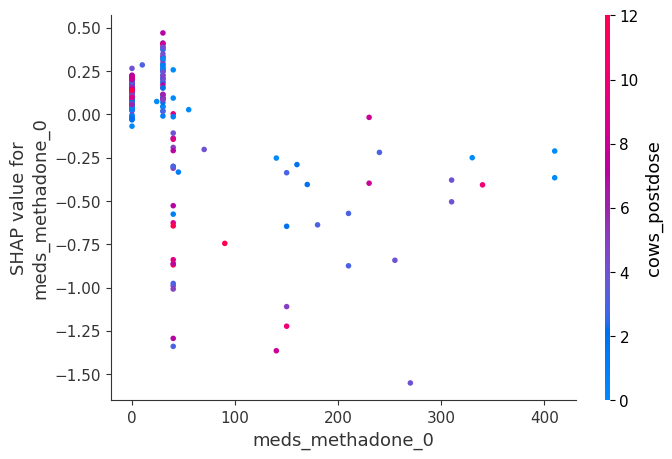

In [40]:

# Create a dependence plot for a specific feature
# Replace 'feature_name' with the actual feature name or index
shap.dependence_plot('meds_methadone_0', shap_values, X_test)